<center><img src=img/MScAI_brand.png width=70%></center>

# Grammars

A **grammar** is a computational device which can:
* *generate* strings from a given formal language, or
* *parse* strings to check that they come from a given language.

There are a few different types of grammar, but we will only study the **context-free grammar**, written in the **Backus-Naur Form** (BNF) notation.

A grammar is a set of *rewrite rules*. Here is an example in BNF:

In [15]:
fname = "code/boolean.bnf"
print(open(fname).read())

<expr> ::= (<expr> <biop> <expr>) | <uop> <expr> | <var> | <const>
<biop> ::= and | or
<uop> ::= not
<var> ::= x[0] | x[1] | x[2]
<const> ::= True | False


Each rule has a left-hand side and a right-hand side separated by the symbol `::=` interpreted as *rewrites to*. The LHS is a single string enclosed in angle brackets. The RHS consists of one or more *productions*, separated by the pipe symbol `|`, interpreted as "or".

A *non-terminal* is a string enclosed in angle brackets. A *terminal* is any other string.

One of the non-terminals is the *start symbol*. In our convention, the non-terminal of the first rule is the start symbol.

### Parsing a string

Parsing a string means starting with a string, and iteratively finding out what rule could have given rise to it, until either:

* We find the complete structure -- a *parsing* -- of the string, showing that it is a valid string in the language; or
* We find that the string is not in the language.

Compilers and interpreters use grammars in this way, e.g. the Python interpreter **parses** your code using a grammar. You can see the Python grammar here: https://docs.python.org/3/reference/grammar.html.

Recall that a piece of Python code corresponds to an Abstract Syntax Tree, like the one shown here. When we say that the Python interpreter parses a piece of code according to the Python grammar, and **finds its structure**, what we mean is that it creates an AST.

<center><img src=img/ast.svg width=35%></center>



### Generating a string from a grammar

Going in the opposite direction also has many applications in AI (we'll see one shortly). By this we mean starting with a grammar and generating a random string from the language:


1. We start with a *derivation* (a string) consisting of just the start symbol;
2. We find the first (left-most) non-terminal in the derivation, and find the rule where that non-terminal is the LHS.
3. We choose one of the productions on the RHS of that rule, and in the derivation, replace the non-terminal with that production.
4. If there are now no non-terminals in the derivation, we stop, else go to 2.

For example (just making **random** choices):
1. `   <expr>`
2. `-> (<expr> <biop> <expr>)`
3. `-> (<var> <biop> <expr>)`
4. `-> (x[0] <biop> <expr>)`
5. `-> (x[0] and <expr>)`
6. `-> (x[0] and <const>)`
7. `-> (x[0] and False)`

The result is a string in the language. We see that this grammar defines a language consisting of Boolean expressions in up to three variables.

### Implementing a grammar for generating strings

The file `code/grammar.py` contains code for reading a grammar in `.bnf` form in, and generating strings from it.

In [5]:
# this is just a hack so we can import from a file in the code directory.
# you don't need to understand this!
import sys
sys.path.insert(1, "code") 

In [ ]:
from grammar import Grammar # import from code/grammar.py

In [2]:
fname = "code/boolean.bnf"
g = Grammar(file_name=fname)

In [3]:
print(g) # notice repr gives a useful output!

Grammar(terminals={'x[1]', 'and', 'or', 'x[2]', '(', 'True', ')', 'not', ' ', 'False', 'x[0]'}, non_terminals={'<expr>', '<var>', '<const>', '<uop>', '<biop>'}, rules={'<expr>': [['(', '<expr>', ' ', '<biop>', ' ', '<expr>', ')'], ['<uop>', ' ', '<expr>'], ['<var>'], ['<const>']], '<biop>': [['and'], ['or']], '<uop>': [['not']], '<var>': [['x[0]'], ['x[1]'], ['x[2]']], '<const>': [['True'], ['False']]}, start_rule='<expr>')


We can now derive (generate) a string at random:

In [19]:
for i in range(5):
    print(g.derive_string())

x[0]
True
False
(False and True)
(x[1] and False)


In fact, we can even turn a string into a piece of code, using `eval` as before, and then run it with appropriate arguments:

In [36]:
s = g.derive_string()
print(s)
f = eval("lambda x: " + s)
f((False, True, False))

(not True and (not not False and x[1]))


False

### Grammars in natural language

Grammars are used in natural language too. For example, this grammar can generate a few simple sentences.

```
<sentence>     ::= <noun_phrase> <verb_phrase>
<noun_phrase>  ::= <noun> | <determiner> <noun>
<determiner>   ::= the | a
<noun>         ::= lion | tiger | antelope
<verb_phrase>  ::= <trans_verb> <noun_phrase> | <intrans_verb>
<trans_verb>   ::= ate | saw | chased
<intrans_verb> ::= slept | rested
```

In [38]:
g = Grammar(file_name="code/animal_sentences.bnf")

In [39]:
for i in range(5):
    print(g.derive_string())

a lion saw antelope
a tiger ate lion
the lion chased the lion
lion saw a antelope
a lion saw tiger


### Randomness and `random.seed`

The `derive_string` generates a string at random. At each step it uses `random.choice(productions)` to choose a random production.



That is often useful, just as generating random numbers is often useful. But in a scientific context, we often want **replicability** as well. How can we reconcile these ideas?

The good news is that internally, the random number generator (RNG) is deterministic -- it is only **pseudo-random**. An arithmetical transform is applied to each number it outputs, to get the next. That transform is complicated but deterministic.

That allows us to achieve replicability. If we start twice from the same state, we'll get the same sequence of random numbers both times.



We can start from a fixed state by **setting the random seed**. The random seed is a number which is like the "start state" of the random number generator (RNG). 

In [44]:
random.seed(73)
for i in range(5):
    print(g.derive_string())

antelope slept
the tiger slept
lion rested
a antelope rested
lion slept


By the way, the `random` module has several other useful functions:

* `random.random()` - a random `float` in $[0, 1]$
* `random.randrange(a, b)` - a random `int` in $[a, b)$
* `random.choice(L)` - a random element of the `list` `L`
* `random.shuffle(L)` - shuffle the `list` `L` in-place

### Generative art - by hand

Let's make a piece of generative art by inventing a formula $p(x, y)$ and simply plotting $p$ over the unit square.

$p$ should be purely numerical, e.g. $p(x, y) = \sin(20x)$. 

We'll use `linspace`, `meshgrid`, and `imshow` (recall our notebook/video on fractals in an earlier week) to make the grid. Here we won't iterate a formula and calculate escape time or anything like that.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [16]:
n = 200
xs = np.linspace(0, 1, n)
ys = np.linspace(0, 1, n)
x, y = np.meshgrid(xs, ys)

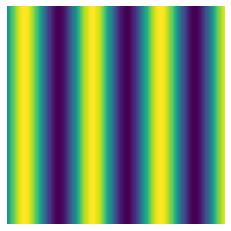

In [17]:
def p(x, y): return np.sin(20 * x)
plt.axis('off'); plt.imshow(p(x, y), cmap=cm.viridis); 

### Generative art - using grammars

"I'd rather write programs that write programs than write programs" -- Richard Sites

Notice that we can also write functions like `p(x, y)` as pure strings, using `eval` as follows:

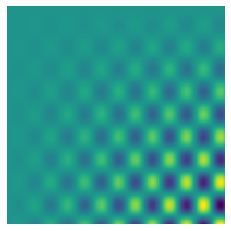

In [18]:
ps = "np.sin(40 * x) * np.sin(30 * (y+0.5)) * x * y"
p = eval("lambda x, y: " + ps)
plt.axis('off'); plt.imshow(p(x, y));

### Exercise

Make a new grammar for *arithmetical expressions in x and y*. Start by copying `code/boolean.bnf` to a new file `code/arithmetic.bnf`. Generate random expressions from that, turn them into functions using `eval`, and visualise them. Try out different colormaps with `cmap`. Think of some more interesting primitive functions to use other than `*`, `sin`, and friends. You can even create more variables (beyond $x$ and $y$), e.g. polar coordinates $r$ and $\theta$.

### Solution

The file `code/arithmetic.bnf` file is supplied with this week's materials.